<a href="https://colab.research.google.com/github/atharvanaik10/face-recognition/blob/master/FaceNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/gdrive')
!pip install mtcnn
from os import listdir
from os.path import isdir
import PIL.Image
import os
import cv2
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
from mtcnn.mtcnn import MTCNN
import pickle

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	print(filename)
	#image = PIL.Image.open(filename)
	pixels = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
	pixels = cv2.resize(pixels, (800, 800))
	# convert to RGB, if needed
	#image = image.convert('RGB')
	# convert to array
	#pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	print(results)
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = PIL.Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array
 
# load images and extract faces for all images in a directory
def load_faces(directory):
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		# get face
		try:
			face = extract_face(path)
			faces.append(face)
		except:
			 print('image failed')	
	return faces
 
# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in listdir(directory):
		# path
		path = directory + subdir + '/'
		# skip any files that might be in the dir
		if not isdir(path):
			continue
		# load all faces in the subdirectory
		faces = load_faces(path)
		# create labels
		labels = [subdir for _ in range(len(faces))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
		X.extend(faces)
		y.extend(labels)
	return asarray(X), asarray(y)
 
# load train dataset
testX, testy = load_dataset('/gdrive/My Drive/Eigenfaces/Dataset2/val/')
trainX, trainy = load_dataset('/gdrive/My Drive/Eigenfaces/Dataset2/train/')
print(trainX.shape, trainy.shape)
print('Algorithm trained')
# load test dataset



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
     |████████████████████████████████| 2.3MB 3.3MB/s 


Using TensorFlow backend.


/gdrive/My Drive/Eigenfaces/Dataset2/val/jay/IMG_6673 10.39.02 PM.JPG










[{'box': [298, 274, 185, 256], 'confidence': 0.9998493194580078, 'keypoints': {'left_eye': (358, 370), 'right_eye': (443, 367), 'nose': (414, 407), 'mouth_left': (375, 467), 'mouth_right': (444, 463)}}]
/gdrive/My Drive/Eigenfaces/Dataset2/val/jay/IMG_6670.JPG
[{'box': [299, 277, 191, 252], 'confidence': 0.9989076852798462, 'keypoints': {'left_eye': (354, 368), 'right_eye': (443, 370), 'nose': (396, 408), 'mouth_left': (355, 463), 'mouth_right': (434, 465)}}]
/gdrive/My Drive/Eigenfaces/Dataset2/val/jay/IMG_6668.JPG
[{'box': [310, 263, 205, 273], 'confidence': 0.9999971389770508, 'keypoints': {'left_eye': (362, 363), 'right_eye': (456, 365), 'nose': (410, 409), 'mouth_left': (367, 464), 'mouth_right': (448, 468)}}]
/gdrive/My Drive/Eigenfaces/Dataset2/val/jay/IMG_6672.JPG
[{'box': [281, 276, 194, 257], 'confidence': 0.9999244213104248, 'keypoints': {'left_eye': (337, 370), 'right_eye': (424, 370), 'nose': (

In [0]:
pickle.dump(testX, open('/gdrive/My Drive/Eigenfaces/Dataset2/pickle/testX.pkl', 'wb'))
pickle.dump(testy, open('/gdrive/My Drive/Eigenfaces/Dataset2/pickle/testy.pkl', 'wb'))

pickle.dump(trainX, open('/gdrive/My Drive/Eigenfaces/Dataset2/pickle/trainX.pkl', 'wb'))
pickle.dump(trainy, open('/gdrive/My Drive/Eigenfaces/Dataset2/pickle/trainy.pkl', 'wb'))

In [0]:
testX = pickle.load(open('/gdrive/My Drive/Eigenfaces/Dataset2/pickle/testX.pkl', 'rb'))
testy = pickle.load(open('/gdrive/My Drive/Eigenfaces/Dataset2/pickle/testy.pkl', 'rb'))
trainX = pickle.load(open('/gdrive/My Drive/Eigenfaces/Dataset2/pickle/trainX.pkl', 'rb'))
trainy = pickle.load(open('/gdrive/My Drive/Eigenfaces/Dataset2/pickle/trainy.pkl', 'rb'))


In [0]:
# calculate a face embedding for each face in the dataset using facenet
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from keras.models import load_model
 
# get the face embedding for one face
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]
 
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)
# load the facenet model
model = load_model('/gdrive/My Drive/Eigenfaces/keras-facenet/model/facenet_keras.h5')
print('Loaded Model')
# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(model, face_pixels)
	print('Embedding shape:', embedding.shape)
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)

Loaded:  (28, 160, 160, 3) (28,) (19, 160, 160, 3) (19,)












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Loaded Model
Embedding shape: (128,)
Embedding shape: (128,)
Embedding shape: (128,)
Embedding shape: (128,)
Embedding shape: (128,)
Embedding shape: (128,)
Embedding shape: (128,)
Embedding shape: (128,)
Embedding shape: (128,)
Embedding shape: (128,)
Embedding shape: (128,)
Embedding shape: (128,)
Embedding shape: (128,)
Embedding shape: (128,)
Embedding shape: (128,)
Embedding shape: (128,)
Embedding shape: (128,)
Embedding shape: (128,)
Embedding shape: (128,)
Embedding shape: (128,)
Embedding shape: (128,)
Embedding shape: (128,)
Embedding shape: (128,)
Embedding shape: (128,)
Embedding shape: (128,)
Embedding shape: (128,)
Embedding shape: (128,)
Embedding shape: (128,)
(28, 128)
(19, 128)


In [0]:
# develop a classifier
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot

testX_faces = testX
# load face embeddings
trainX, trainy, testX, testy = newTrainX, trainy, newTestX, testy
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
face_clf_model = SVC(kernel='linear', probability=True)
face_clf_model.fit(trainX, trainy)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [0]:
pickle.dump(face_clf_model, open('/gdrive/My Drive/Eigenfaces/Dataset2/pickle/clfmodel.pkl', 'wb'))

Predicted: rahil (56.953)
Expected: rahil


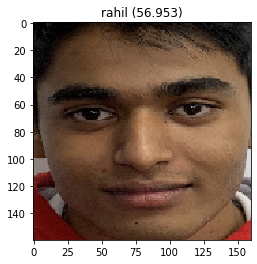

In [0]:
# test model on a random example from the test dataset
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])
# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = face_clf_model.predict(samples)
yhat_prob = face_clf_model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])
# plot for fun
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()

In [0]:
def facedim(filename, required_size=(160, 160)):
	# load image from file
	print(filename)
	#image = PIL.Image.open(filename)
	pixels = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
	pixels = cv2.resize(pixels, (1280, 720))
	# convert to RGB, if needed
	#image = image.convert('RGB')
	# convert to array
	#pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
  # extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = PIL.Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return (x1,y1),(x2,y2), face_array

In [0]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='/gdrive/My Drive/Eigenfaces/Input/photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [0]:
from IPython.display import Image
try:
  filename = take_photo()
  print(filename)

except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

/gdrive/My Drive/Eigenfaces/Input/photo.jpg


/gdrive/My Drive/Eigenfaces/Input/photo.jpg
Face extracted...
Analysing face...
Welcome dr s


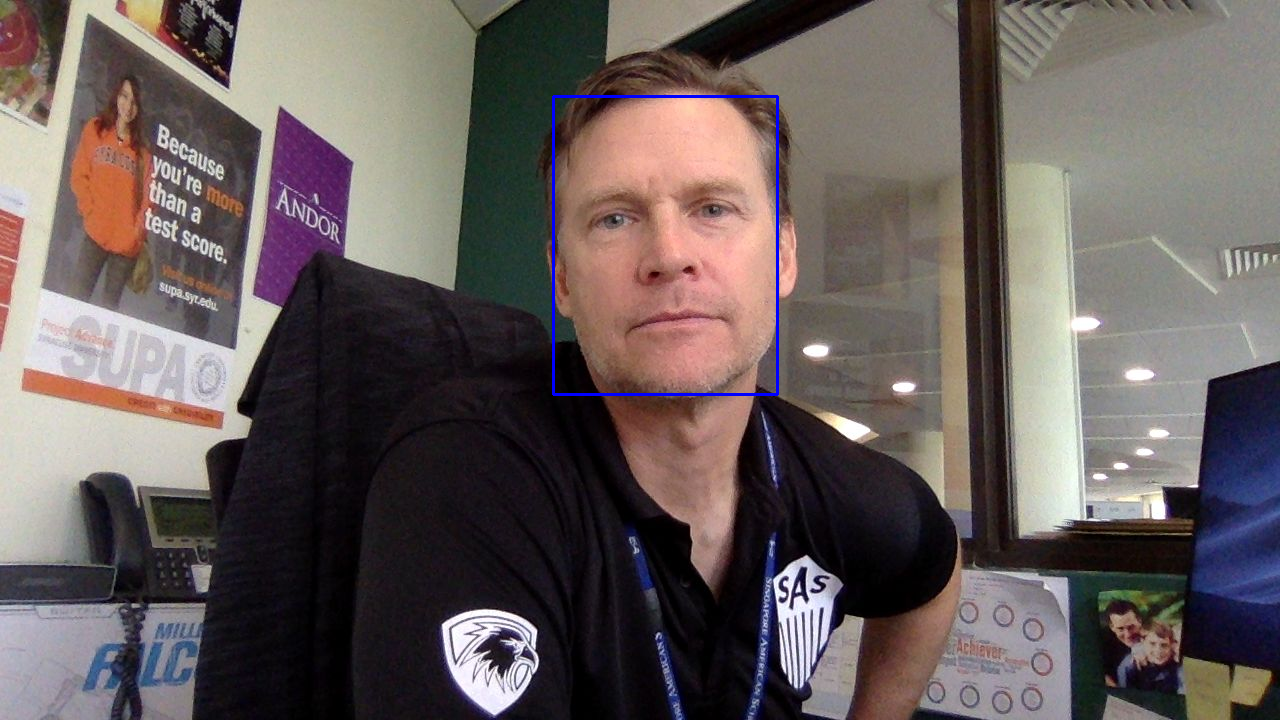

In [0]:
from google.colab.patches import cv2_imshow

start, end, inputX = facedim('/gdrive/My Drive/Eigenfaces/Input/photo.jpg')


print('Face extracted...')
print('Analysing face...')
inputlist = list()
inputlist.append(inputX)
ntx = get_embedding(model, inputlist[0])
ntx = asarray(ntx)

#ntx = in_encoder.transform(ntx)
# prediction for the face
samples = expand_dims(ntx, axis=0)
yhat_class = face_clf_model.predict(samples)
yhat_prob = face_clf_model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
#display(Image(filename))
imgout = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
imgout = cv2.resize(imgout, (1280,720))
imgout = cv2.rectangle(imgout, start, end, (255,0,0), 2)
print('Welcome %s' % (predict_names[0]))
cv2_imshow(imgout) 